# Importiere Libraries

In [15]:
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "wandb", "--upgrade"])

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optimizers
import torch.nn as nn
from torch.functional import F
from torch.utils.data import Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import wandb
from torchview import draw_graph
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import IFrame

team = "t_buess"
project_name = "del_mc1" #universeller wandb Projektname
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.abspath("") #set notebook name

wandb.login()
wandb_api = wandb.Api()

train_len_percent = 0.8 #x prozent sind trainings daten, der rest validierungsdaten

wandb: Currently logged in as: buesst1 (t_buess). Use `wandb login --relogin` to force relogin


# Info

Sollte das Notebook ausgeführt werden, dann muss die Ausführung der Codezellen in folgender Reihenfolge erfolgen:

Reihenfolge:
1. Alle Codeblöcke vom start des Notebooks bis zum Markdown mit **Evaluierung** ausführen (Die Codeblöcke welche zu **Evaluierung** gehören dürfen noch nicht ausgeführt werden)
2. **Bestes modell** (alle dazugehörigen Codeblöcke)
3. **Nutzen der Regularisierung** (alle dazugehörigen Codeblöcke)
4. **Nutzen von Batchnorm** (nur die Codeblöcke wo *WANDB_train_validate_cv* oder *WANDB_simple_train_test* verwendet werden)
5. **Hyperparameter tuning** (alle dazugehörigen Codeblöcke)
6. **Nutzen von Batchnorm** (nur die Codeblöcke wo *WANDB_optimize_hyperparams* verwendet wird)
7. **Adam optimizer** (alle dazugehörigen Codeblöcke)

Diese Reihenfolge muss leider eingehalten werden, da die Klasse *WANDB_optimize_hyperparams* die WandB Sweep Funtkionalität nutzt.

Sobald diese einmal gestartet wurde, kann WandB irgendwie nicht mehr disen 'Sweepmodus' verlassen, bis der Kernel neu gestartet wurde.

Deshalb müssen zuerst alle Codeblöcke ausgeführt werden, welche *WANDB_simple_train_test* oder *WANDB_train_validate_cv* nutzen, bevor *WANDB_optimize_hyperparams* gestartet wird.

Eine weitere Möglichkeit wäre das Notebook normal laufen zu lassen, bis *WANDB_optimize_hyperparams* verwendet wird.

Sollte jupyter zu einer Zelle gelangen, welche anschliessend *WANDB_simple_train_test* oder *WANDB_train_validate_cv* verwendet, muss der Kernel neu gestartet werden.

Anschliessend müssen die Imports neu gemacht werden, die Code Zellen von **Trainingsfunktionalität**, **Lade Datenset und erstelle zusätzliches validierungs Datenset** und **Modelle welche getestet werden** ausgeführt werden und dann kann dort weitergemacht werden, wo jupyter war, bevor der Kernel neu gestartet wurde.

Dieser Kernel Neustart mit dieser 'Initialisierung' muss jedes Mal gemacht werden, wenn man nach *WANDB_optimize_hyperparams* wieder bei *WANDB_simple_train_test* oder *WANDB_train_validate_cv* angelangt.

Ich entschuldige mich dafür, dass für das Ausführen so ein grosser Aufwand betrieben werden muss, allerdings wäre das Umschreiben der Trainingsfunktionalität auf Sweep only ein zu Fehleranfälliger und grosser Aufwand gewesen.

# Trainingsfunktionalität

In [2]:
class WANDB_simple_train_test:
    def __init__(self, wandb_project_name:str, hyperparams:dict, device:str, model_class:nn.Module, optimizer_class=optimizers.SGD, criterion_class=nn.CrossEntropyLoss) -> None:
        """Train and test model normal
        Args:
            wandb_project_name (str): project name
            hyperparams (dict): hyperparameters for training {requires: 'optimizer_kwargs', 'num_classes', 'batchsize', 'dl_num_workers', 'dl_shuffle', 'epochs'}
            device (str): device to train on
            model_class (class): class with model
            optimizer_class (class): class with optimizer
            criterion_class (class): class with criterion
        """
        
        self._device = device #device to train the data on
        self._hyperparams = hyperparams.copy() #hyperparameters for training
        self._wandb_project_name = wandb_project_name #project name for wandb

        #store model name as parameter
        if "model" in self._hyperparams.keys():
            raise Exception("model already exists in hyperparams")
        self._hyperparams["model"] = model_class.__name__ #set model name as class name

        #store classes which are needed
        self._model_class = model_class
        self._optimizer_class = optimizer_class
        self._criterion_class = criterion_class

    def start(self, train_dataset:Dataset, test_dataset:Dataset=None, valid_dataset:Dataset=None, run_id:str=None, detailed_logging=True) -> nn.Module:
        """ Start training of model (batch training and log every log_batch_period's batch). Evaluate loss on whole train and test set at logging.
        Args:
            train_dataset (Dataset): data to train on 
            test_dataset (Dataset): data to test on (if none no testing will be performed)
            valid_dataset (Dataset): data to validate on (if none no validation will be performed)
            run_id (str): run id or run name
            detailed_logging (bool): if true -> also log device metrics

        Returns:
            trained model
        """

        #init wandb run
        with wandb.init(project=self._wandb_project_name, config=self._hyperparams, id=run_id) as run:
            config = wandb.config

            model:nn.Module = self._model_class().to(self._device) #create a new model from class and move to device
            optimizer = self._optimizer_class(model.parameters(), **config["optimizer_kwargs"]) #create optimizer and pass parameters form model, pass optimizer kwargs
            criterion = self._criterion_class() #create new criterion

            if detailed_logging:
                wandb.watch(model, criterion, log="all", log_freq=10) #log system and pytorch parameters

            train_loader = DataLoader(train_dataset, config["batchsize"], num_workers=config["dl_num_workers"], shuffle=config["dl_shuffle"], pin_memory=True, persistent_workers=True) #make train loader

            test_inputs = test_targets = None #set to none
            if test_dataset != None: #check if test dataset is available
                test_inputs, test_targets = DataLoader(test_dataset, batch_size=len(test_dataset), pin_memory=True).__iter__().__next__() #load full test data

            valid_inputs = valid_targets = None #set to none
            if valid_dataset != None: #check if validation dataset is available
                valid_inputs, valid_targets = DataLoader(valid_dataset, batch_size=len(valid_dataset), pin_memory=True).__iter__().__next__() #load full validation data

            for i, metrics in enumerate(WANDB_simple_train_test.train_eval_model(config, self._device, model, optimizer, criterion, train_loader, test_inputs, test_targets, valid_inputs, valid_targets)):
                #### log metrics every epoch####
                wandb.log(metrics, step = i) #set steps to epoch

            #set model to evaluation mode      
            model.eval()

            #upload model and visualization to wandb
            X, _ = next(train_loader.__iter__())
            WANDB_simple_train_test.store_model(model, X[[0]])

            del train_loader #shutdown workers

            return model
        
    @staticmethod
    def store_model(model: nn.Module, X:torch.Tensor):
        #upload model to wandb
        torch.onnx.export(model.cpu(), X.cpu(), os.path.join(wandb.run.dir, "model.onnx"), input_names=["features"], output_names=["output"])
        wandb.save('model.onnx')

        #make a visualization of the model and upload to wandb
        draw_graph(model.cpu(), input_data=X.cpu()).visual_graph.render(outfile=os.path.join(wandb.run.dir, "model.png"), format="png")
        wandb.log({"model_struct_viz": wandb.Image(Image.open(os.path.join(wandb.run.dir, "model.png")))})

    @staticmethod
    def train_eval_model(config:dict, device:str, model:nn.Module, optimizer:optimizers, criterion:nn, train_loader:DataLoader, test_inputs:torch.Tensor=None, test_targets:torch.Tensor=None, valid_inputs:torch.Tensor=None, valid_targets:torch.Tensor=None):
        """ Train and evaluate model & yield metrics
        Args:
            config (dict): config for training 
            device (str): device to train on
            model (nn.Module): model instance
            optimizer (optimizers): optimizer
            criterion (nn): loss function
            train_loader (DataLoader): dataloader
            test_inputs (Tensor): inputs for test (optional)
            test_targets (Tensor): targets for test (optional)
            valid_inputs (Tensor): inputs for validation (optional)
            valid_targets (Tensor): targets for validation (optional)

        Yields:
            dictionary with metrics
        """

        def add_regulartization_to_loss(loss:torch.Tensor):
            """adds regularization to loss
            """
            alpha = config.get("alpha", 0) #get alpha and if not provided -> initialize with 0

            #only execute if alpha > 0
            if alpha > 0: 
                layers = [module for module in model.modules() if not isinstance(module, model.__class__)] #get all layers from model

                linear_layers = [layer for layer in layers if isinstance(layer, nn.Linear)] #get all linear layers

                all_linear_weights = torch.cat([layer.weight.view(-1) for layer in linear_layers]) #get all weights from linear layer

                regularization = alpha * torch.norm(all_linear_weights, config["l_regularization"]) #calculate regularization therm

                return loss + regularization #add regularization to loss
            
            return loss

        def get_metrics(input:torch.Tensor, target:torch.Tensor):
            """Get metrics from input and targets
            Args:
                input (torch.Tensor): input for model
                target (torch.Tensor): targets
            Returns:
                tuple(loss, accuracy)
            """
            
            #### Start evaluation ####
            model.eval() #set model to eval mode

            with torch.no_grad(): #disable gradient calculation
                input, target = input.to(device), target.to(device) #move data to gpu

                predicted:torch.Tensor = model(input) #predict

                loss = add_regulartization_to_loss(criterion(predicted, target)).item() #calculate loss and add regularization to it if required

                num_correct = (torch.max(predicted.data, 1)[1] == target).sum().item() #calculate number of correct predictions

                accuracy = num_correct / len(target) #calculate accuracy

                return loss, accuracy #return metrics 
        
        def evaluate_before_training():
            """Measures performance before training starts
            """

            #### Start evaluation before training ####
            with torch.no_grad(): #disable gradient calculation
                model.eval() #set model to eval mode

                epoch_num_pred_correct = 0 #number of correct predictions stored here
                epoch_summed_loss = 0 #summed loss stored here
                epoch_num_samples = 0 #number of samples stored here
                for batch_inputs, batch_targets in train_loader: #iterate over batches
                    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device) #move batch train data to gpu

                    batch_predicted:torch.Tensor = model(batch_inputs) #make a prediction

                    batch_loss:torch.Tensor = add_regulartization_to_loss(criterion(batch_predicted, batch_targets)) #calculate loss and add regularization if required

                    epoch_num_samples += len(batch_targets) #add number of samples in this epoch
                    epoch_summed_loss += batch_loss.item() * len(batch_targets) #add batch loss to variable
                    epoch_num_pred_correct += (torch.max(batch_predicted.data, 1)[1] == batch_targets).sum().item() #calculate number of correct predictions and add to variable
                
                #### Start testing / validation
                train_loss = epoch_summed_loss / epoch_num_samples #calculate train loss of whole epoch
                train_accuracy = epoch_num_pred_correct / epoch_num_samples #calculate accuracy

                #dictionary that will be sent to wandb
                log_dict = {
                    "epoch": 0, #log epoch 0 
                    "train_loss": train_loss, #train loss
                    "train_accuracy": train_accuracy, #train accuracy
                }

                #if test available
                if test_inputs != None and test_targets!= None:
                    test_loss, test_accuracy = get_metrics(test_inputs, test_targets)

                    log_dict["test_loss"] = test_loss
                    log_dict["test_accuracy"] = test_accuracy

                #if validation available
                if valid_inputs != None and valid_targets!= None:
                    valid_loss, valid_accuracy = get_metrics(valid_inputs, valid_targets)

                    log_dict["valid_loss"] = valid_loss
                    log_dict["valid_accuracy"] = valid_accuracy

                return log_dict #return log dictionary
        
        #evaluate model before training starts to compare starting point
        yield evaluate_before_training()

        ### Start training of model
        for epoch in range(1, config["epochs"] + 1): #iterate over epochs (start from epoch 1)
                #### Train on epoch
                model.train() #set model to train mode

                epoch_num_pred_correct = 0 #number of correct predictions stored here
                epoch_summed_loss = 0 #summed loss stored here
                epoch_num_samples = 0 #number of samples stored here
                for batch_inputs, batch_targets in train_loader: #iterate over batches
                    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device) #move batch train data to gpu

                    optimizer.zero_grad() #set gradient to zero

                    batch_predicted:torch.Tensor = model(batch_inputs) #make a prediction

                    batch_loss:torch.Tensor = add_regulartization_to_loss(criterion(batch_predicted, batch_targets)) #calculate loss and add regularization if required

                    batch_loss.backward() #calculate gradient
                    optimizer.step() #update parameters

                    epoch_num_samples += len(batch_targets) #add number of samples in this epoch
                    epoch_summed_loss += batch_loss.item() * len(batch_targets) #add batch loss to variable
                    epoch_num_pred_correct += (torch.max(batch_predicted.data, 1)[1] == batch_targets).sum().item() #calculate number of correct predictions and add to variable
                
                #### Start testing / validation
                train_loss = epoch_summed_loss / epoch_num_samples #calculate train loss of whole epoch
                train_accuracy = epoch_num_pred_correct / epoch_num_samples #calculate accuracy

                #dictionary that will be sent to wandb
                log_dict = {
                    "epoch": epoch, #log epoch
                    "train_loss": train_loss, #train loss
                    "train_accuracy": train_accuracy, #train accuracy
                }

                #if test available
                if test_inputs != None and test_targets!= None:
                    test_loss, test_accuracy = get_metrics(test_inputs, test_targets)

                    log_dict["test_loss"] = test_loss
                    log_dict["test_accuracy"] = test_accuracy

                #if validation available
                if valid_inputs != None and valid_targets!= None:
                    valid_loss, valid_accuracy = get_metrics(valid_inputs, valid_targets)

                    log_dict["valid_loss"] = valid_loss
                    log_dict["valid_accuracy"] = valid_accuracy

                yield log_dict

class WANDB_optimize_hyperparams:
    def __init__(self, wandb_project_name:str, device:str, model_class:nn.Module, optimizer_class=optimizers.SGD, criterion_class=nn.CrossEntropyLoss) -> None:
        """Hyperparameter optimization of a model with wandb grid sweeps and kfold cross validation
        Args:
            wandb_project_name (str): project name
            device (str): device to train on
            model_class (class): class with model
            optimizer_class (class): class with optimizer
            criterion_class (class): class with criterion
        """
        
        self._device = device #device to train the data on
        self._wandb_project_name = wandb_project_name #project name for wandb

        #store classes which are needed
        self._model_class = model_class
        self._optimizer_class = optimizer_class
        self._criterion_class = criterion_class

    def start(self, sweep_name:str, parameters:dict, train_dataset:Dataset, test_dataset:Dataset, validation_dataset:Dataset=None, detailed_logging=True, cv=False):
        """Start optimization 
        Args:
            sweep_name (str): name of sweep
            parameters (dict): parameters required for sweeping {requires: 'batchsize', 'num_classes', 'dl_num_workers', 'dl_shuffle', 'optimizer_kwargs', 'epochs', 'k_folds'}
            train_dataset (Dataset): dataset to perform the training (if cv == True -> also do validation on this dataset)
            test_dataset (Dataset): dataset to test on
            validation_dataset (Dataset):  dataset to validate on (only used if cv == False)
            detailed_logging (bool): if true -> also log device metrics
            cv (bool): True -> Perform cross validation on train_dataset
        """

        ### try store model name in parameters
        parameters = parameters.copy() #make a copy of the parameters
        #store model name as parameter
        if "model" in parameters.keys():
            raise Exception("model already exists in parameters")
        parameters["model"] = {'values': [self._model_class.__name__]} #store model name as parameter

        if cv: #perform cross validation
            def cross_validate():
                """Do a cross validation on train_dataset
                """

                with wandb.init() as run:
                    config = wandb.config                 

                    #store metrics from cv here
                    valid_accuracies = []
                    folds_metrics = []
                    for valid_set, train_set in WANDB_optimize_hyperparams.get_sampler(train_dataset, config["k_folds"]):
                        train_loader = DataLoader(train_set, config["batchsize"], num_workers=config["dl_num_workers"], shuffle=config["dl_shuffle"], pin_memory=True, persistent_workers=True) #make train loader
                        valid_inputs, valid_targets = DataLoader(valid_set, batch_size=len(valid_set), pin_memory=True).__iter__().__next__() #load full validation data
                        test_inputs, test_targets = DataLoader(test_dataset, batch_size=len(test_dataset), pin_memory=True).__iter__().__next__() #load full test data

                        ## prepare model, optimizer and criterion
                        model:nn.Module = self._model_class().to(self._device) #create a new model from class and move to device
                        optimizer = self._optimizer_class(model.parameters(), **config["optimizer_kwargs"]) #create optimizer and pass parameters form model, pass optimizer kwargs
                        criterion = self._criterion_class() #create new criterion

                        if detailed_logging:
                            wandb.watch(model, criterion, log="all", log_freq=10) #log system and pytorch parameters

                        metrics_during_train = {} #store metrics during training
                        for i, metrics in enumerate(WANDB_simple_train_test.train_eval_model(config, self._device, model, optimizer, criterion, train_loader, valid_inputs=valid_inputs, valid_targets=valid_targets, test_inputs=test_inputs, test_targets=test_targets)):
                            for key, value in metrics.items():
                                metrics_during_train[key] = metrics_during_train.get(key, []).append(value)

                        folds_metrics.append(metrics_during_train) #store train metrics to list
                            
                        valid_accuracies.append(metrics["valid_accuracy"]) #append last validation accuracy of training

                    #log metric chart with respect to fold
                    x_axis = folds_metrics[0]["epoch"] #get epoch as x axis
                    for metric_name in folds_metrics[0].keys(): #iterate over metrics
                        if metric_name != "epoch": #if its not epoch
                             
                            wandb.log({
                                "my_custom_id": wandb.plot.line_series(
                                    xs=x_axis, 
                                    ys=[fold_metrics[metric_name] for fold_metrics in folds_metrics],
                                    keys=[f"fold_{i}" for i in range(len(folds_metrics))],
                                    title=f"{metric_name}",
                                    xname="epoch")
                                })

                    #log mean validation accuracy
                    wandb.log(
                        {
                            "mean_valid_accuracy": np.mean(valid_accuracies) #calculate mean validation accuracy
                        })
                    
                    #upload model and visualization to wandb
                    X, _ = next(train_loader.__iter__())
                    WANDB_simple_train_test.store_model(model, X[[0]])

                    del train_loader #shutdown workers
            
            #create sweep config from parameters
            sweep_config = {
                "name": sweep_name,
                'metric': {'goal': 'maximize', 'name': 'mean_valid_accuracy'}, #maximize validation accuracy
                "method": "grid",
                "parameters": parameters
            }
                        
            sweep_id = wandb.sweep(sweep_config, project=self._wandb_project_name) #initialize sweep
            wandb.agent(sweep_id, cross_validate)

        else: #perform simple grid search
            def train_test():
                """Train and test normally
                """
                
                with wandb.init() as run:
                    config = wandb.config

                    ## Create train dataloader and prepare test data
                    train_loader = DataLoader(train_dataset, config["batchsize"], num_workers=config["dl_num_workers"], shuffle=config["dl_shuffle"], pin_memory=True, persistent_workers=True) #make train loader
                    test_inputs, test_targets = DataLoader(test_dataset, batch_size=len(test_dataset), pin_memory=True).__iter__().__next__() #load full test data
                    valid_inputs, valid_targets = DataLoader(validation_dataset, batch_size=len(validation_dataset), pin_memory=True).__iter__().__next__() #load full validation data

                    ## prepare model, optimizer and criterion
                    model:nn.Module = self._model_class().to(self._device) #create a new model from class and move to device
                    optimizer = self._optimizer_class(model.parameters(), **config["optimizer_kwargs"]) #create optimizer and pass parameters form model, pass optimizer kwargs
                    criterion = self._criterion_class() #create new criterion

                    if detailed_logging:
                        wandb.watch(model, criterion, log="all", log_freq=10) #log system and pytorch parameters

                    for i, metrics in enumerate(WANDB_simple_train_test.train_eval_model(config, self._device, model, optimizer, criterion, train_loader, test_inputs=test_inputs, test_targets=test_targets, valid_inputs=valid_inputs, valid_targets=valid_targets)):
                        #### log metrics every epoch####
                        wandb.log(metrics, step = i) #set steps to epoch    

                    #upload model and visualization to wandb
                    X, _ = next(train_loader.__iter__())
                    WANDB_simple_train_test.store_model(model, X[[0]])

                    del train_loader #shutdown workers

            #create sweep config from parameters
            sweep_config = {
                "name": sweep_name,
                'metric': {'goal': 'maximize', 'name': 'valid_accuracy'}, #maximize validation accuracy
                "method": "grid",
                "parameters": parameters
            }
                        
            sweep_id = wandb.sweep(sweep_config, project=self._wandb_project_name) #initialize sweep
            wandb.agent(sweep_id, train_test)
            
    @staticmethod
    def get_sampler(train_dataset:Dataset, k_folds:int):
        """Divide train_dataset into folds

        Yields:
            validation_dataset, train_dataset
        """

        #create shuffled array with all indices
        indices_shuffled = np.arange(len(train_dataset)) #unshuffled
        np.random.shuffle(indices_shuffled) #shuffle

        folds_indices = np.array_split(indices_shuffled, k_folds) #divide indices into k folds

        for i_valid in range(len(folds_indices)):
            indices_valid = folds_indices[i_valid]
            indices_train = np.hstack(folds_indices[:i_valid] + folds_indices[i_valid+1:]) #select all indices except for the validation fold

            #split up dataset into validation and train dataset
            valid_set:Dataset = Subset(train_dataset, indices_valid)
            train_set:Dataset = Subset(train_dataset, indices_train)

            yield  valid_set, train_set

class WANDB_train_validate_cv:
    def __init__(self, wandb_project_name:str, cv_name:str, hyperparams:dict, device:str, model_class:nn.Module, optimizer_class=optimizers.SGD, criterion_class=nn.CrossEntropyLoss) -> None:
        """Train a model and do k-fold cross validation -> how does the model perform with respect to loss and accuracy with different initializations and samples
        Args:
            wandb_project_name (str): project name
            cv_name (str): name of validation (will be part of the run id later)
            hyperparams (dict): hyperparameters for training {requires: 'optimizer_kwargs', 'num_classes', 'batchsize', 'dl_num_workers', 'dl_shuffle', 'epochs'}
            device (str): device to train on
            model_class (class): class with model
            optimizer_class (class): class with optimizer
            criterion_class (class): class with criterion
        """
        
        self._device = device #device to train the data on
        self._hyperparams = hyperparams.copy() #hyperparameters for training
        self._wandb_project_name = wandb_project_name #project name for wandb

        #store validation as parameter
        if "cv_name" in self._hyperparams.keys():
            raise Exception("cv_name already exists in hyperparams")
        self._hyperparams["cv_name"] = cv_name #set name

        #store classes which are needed
        self._model_class = model_class
        self._optimizer_class = optimizer_class
        self._criterion_class = criterion_class

    def start(self, train_dataset:Dataset, test_dataset:Dataset, detailed_logging=True):
        """Start training with cross validation
        Args:
            train_dataset (Dataset): dataset to train on
            test_dataset (Dataset): dataset to test on
            detailed_logging (bool): log system metrics in detail if True
        """
        #iterate over folds
        for i, (valid_set, train_set) in enumerate(WANDB_optimize_hyperparams.get_sampler(train_dataset, self._hyperparams["k_folds"])):

            WANDB_simple_train_test(
                self._wandb_project_name,
                self._hyperparams, 
                self._device, 
                self._model_class, 
                self._optimizer_class, 
                self._criterion_class).start(train_set, valid_dataset=valid_set, test_dataset=test_dataset, run_id=f"{self._hyperparams['cv_name']}_{i}", detailed_logging=detailed_logging)

# Lade Datenset und erstelle zusätzliches validierungs Datenset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #führe transformation durch

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) #lade trainings datensatz

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) #lade test datensatz

def split(dataset:Dataset, proportion_train=0.8, seed=42):
    np.random.seed(seed)
    targets = np.array(dataset.targets)

    train_indices = []
    test_indices = []
    for class_ in np.unique(targets):
        class_indices = np.argwhere(targets == class_).flatten()
        
        #get indices for train
        mask_train = np.random.choice(range(len(class_indices)), size=int(len(class_indices)*proportion_train), replace=False)
        train_indices_class = class_indices[mask_train]

        #get indices for test
        mask = np.ones(len(class_indices), dtype=bool)
        mask[mask_train] = False
        test_indices_class = class_indices[mask]

        #extend
        train_indices.extend(list(train_indices_class))
        test_indices.extend(list(test_indices_class))

    #shuffle indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    np.random.seed(None)

    return Subset(dataset, train_indices), Subset(dataset, test_indices)

trainset, validationset = split(trainset_full, proportion_train=train_len_percent) #splitte in train und validierungs set

Files already downloaded and verified
Files already downloaded and verified


# Datensatz kennenlernen

In [4]:
def show_image_classes(dataset:Dataset, title:str):
    if isinstance(dataset, Subset):
        fig, ax = plt.subplots(1, len(dataset.dataset.classes),figsize=(50, 10))
        for i, class_ in enumerate(dataset.dataset.classes):
            index = np.argwhere(np.array(dataset.dataset.targets)[dataset.indices].flatten() == i).flatten()[0]
            ax[i].imshow(dataset.dataset.data[dataset.indices][index])
            ax[i].set_xlabel(class_)
        plt.suptitle(title)
        plt.show()

    else:
        fig, ax = plt.subplots(1, len(dataset.classes),figsize=(50, 10))
        for i, class_ in enumerate(dataset.classes):
            index = np.argwhere(np.array(dataset.targets).flatten() == i).flatten()[0]
            ax[i].imshow(dataset.data[index])
            ax[i].set_xlabel(class_)
        plt.suptitle(title)
        plt.show()

Data shape von train Dataset (40000, 32, 32, 3)


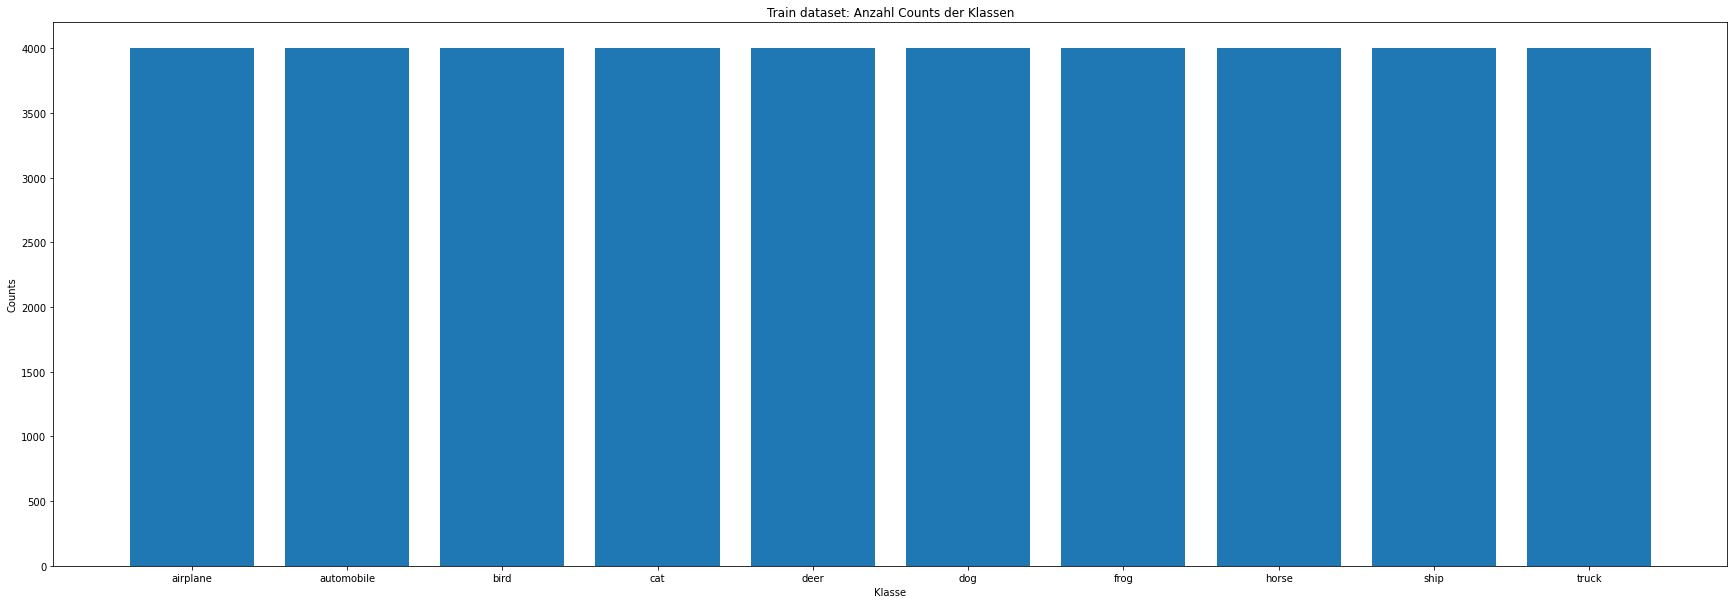

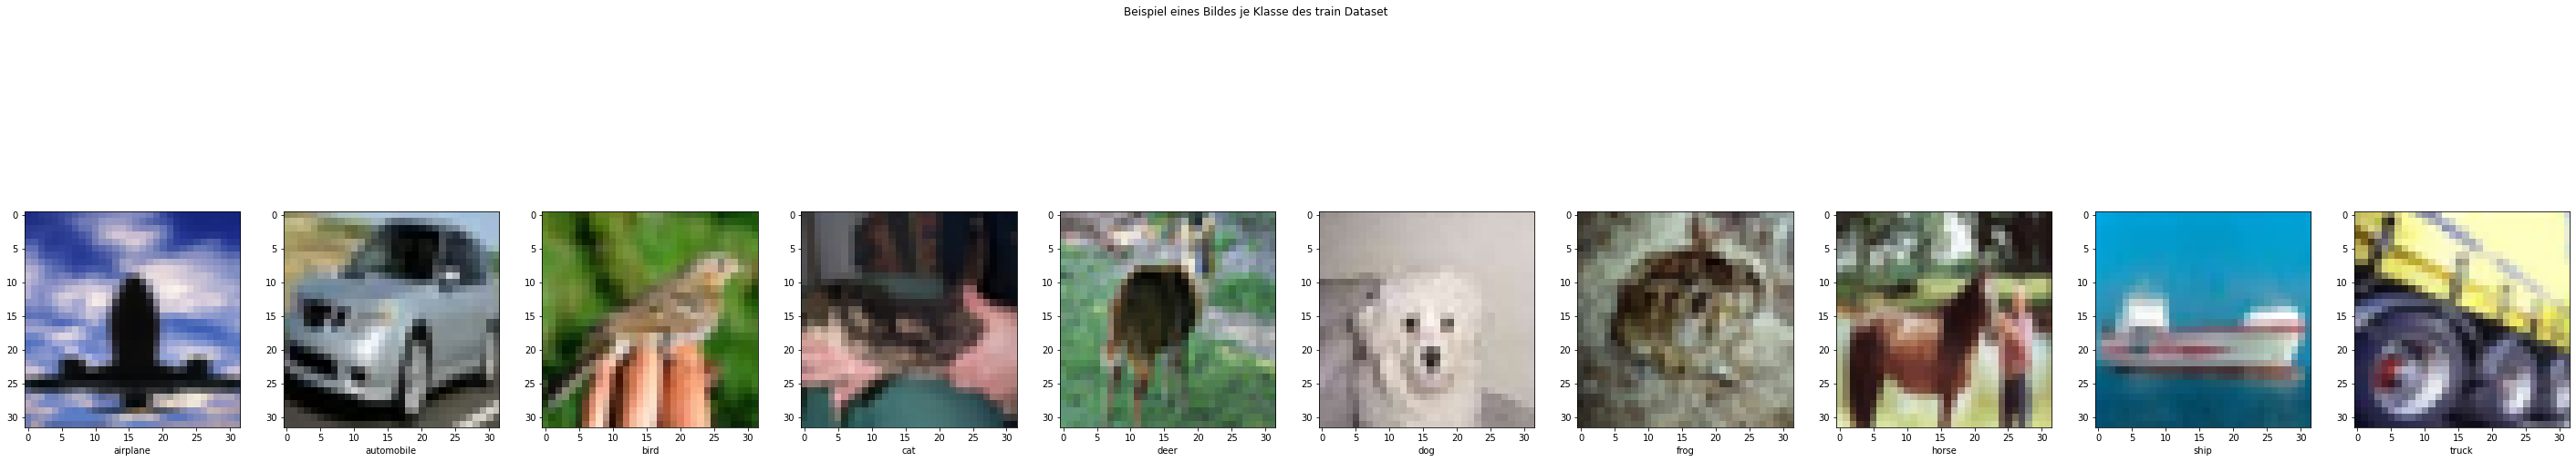

Data shape von validierungs-Dataset (10000, 32, 32, 3)


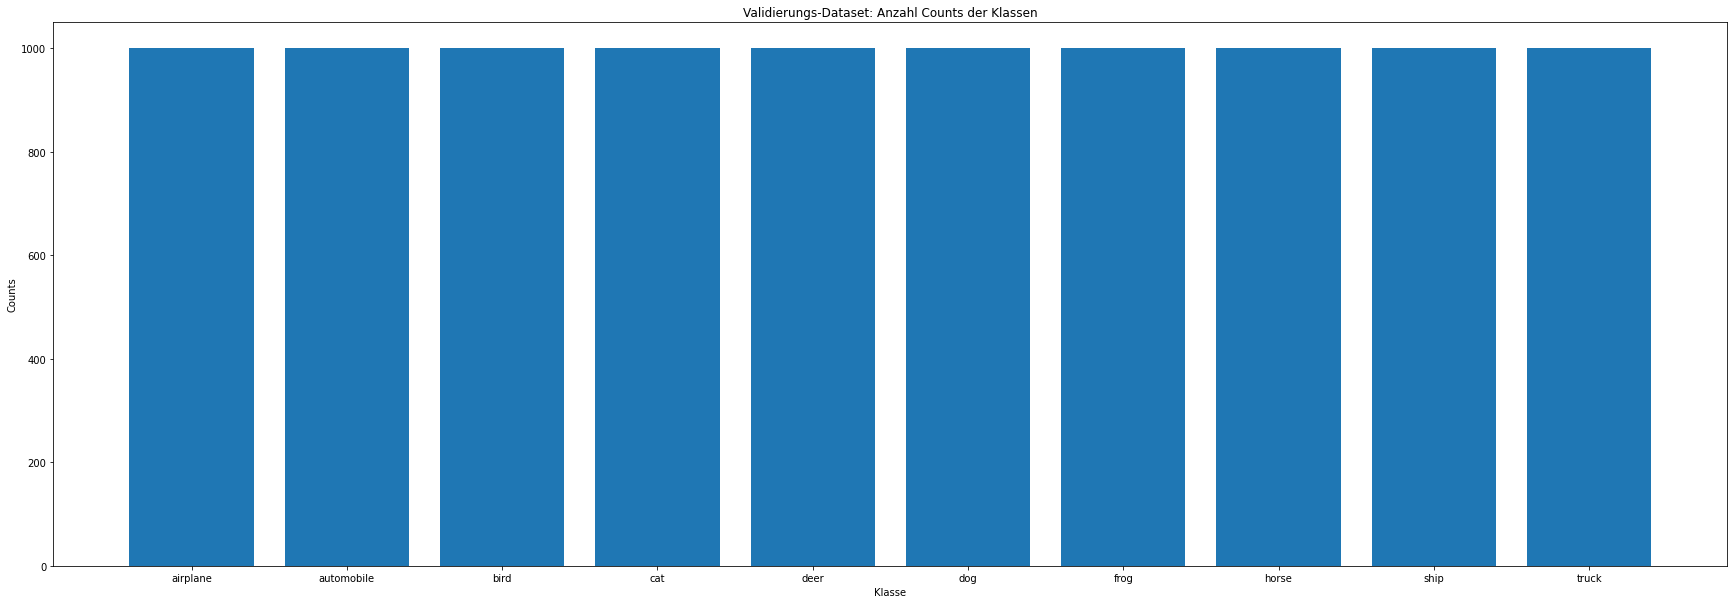

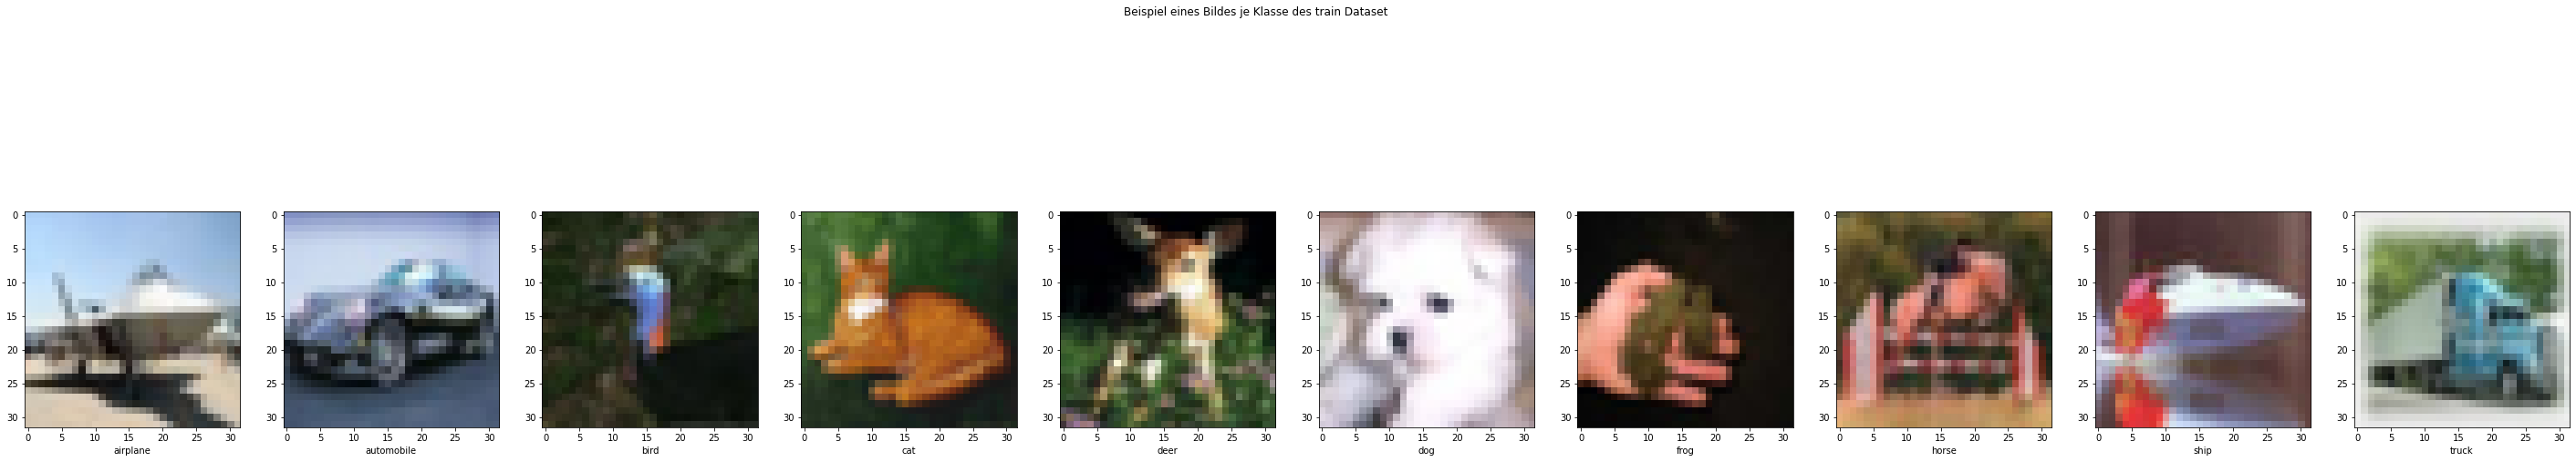

Data shape von test Dataset (10000, 32, 32, 3)


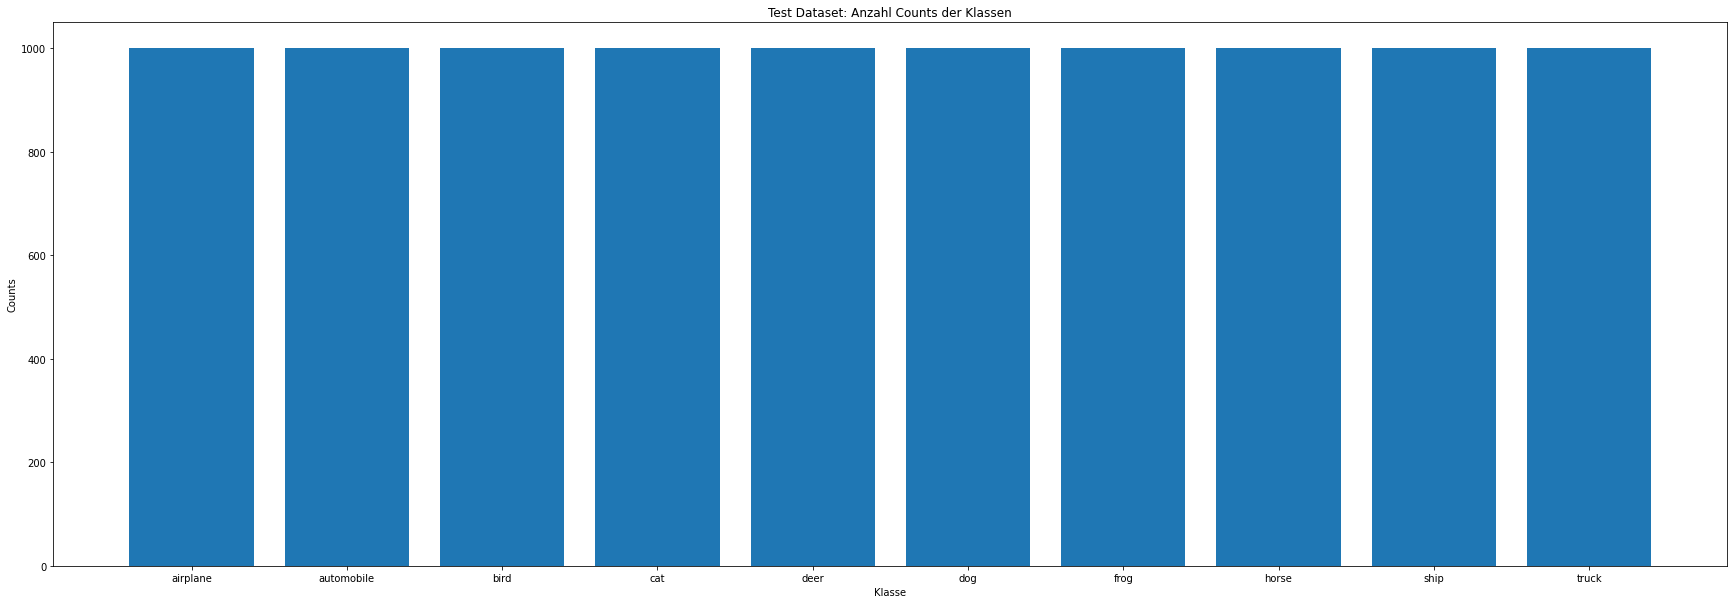

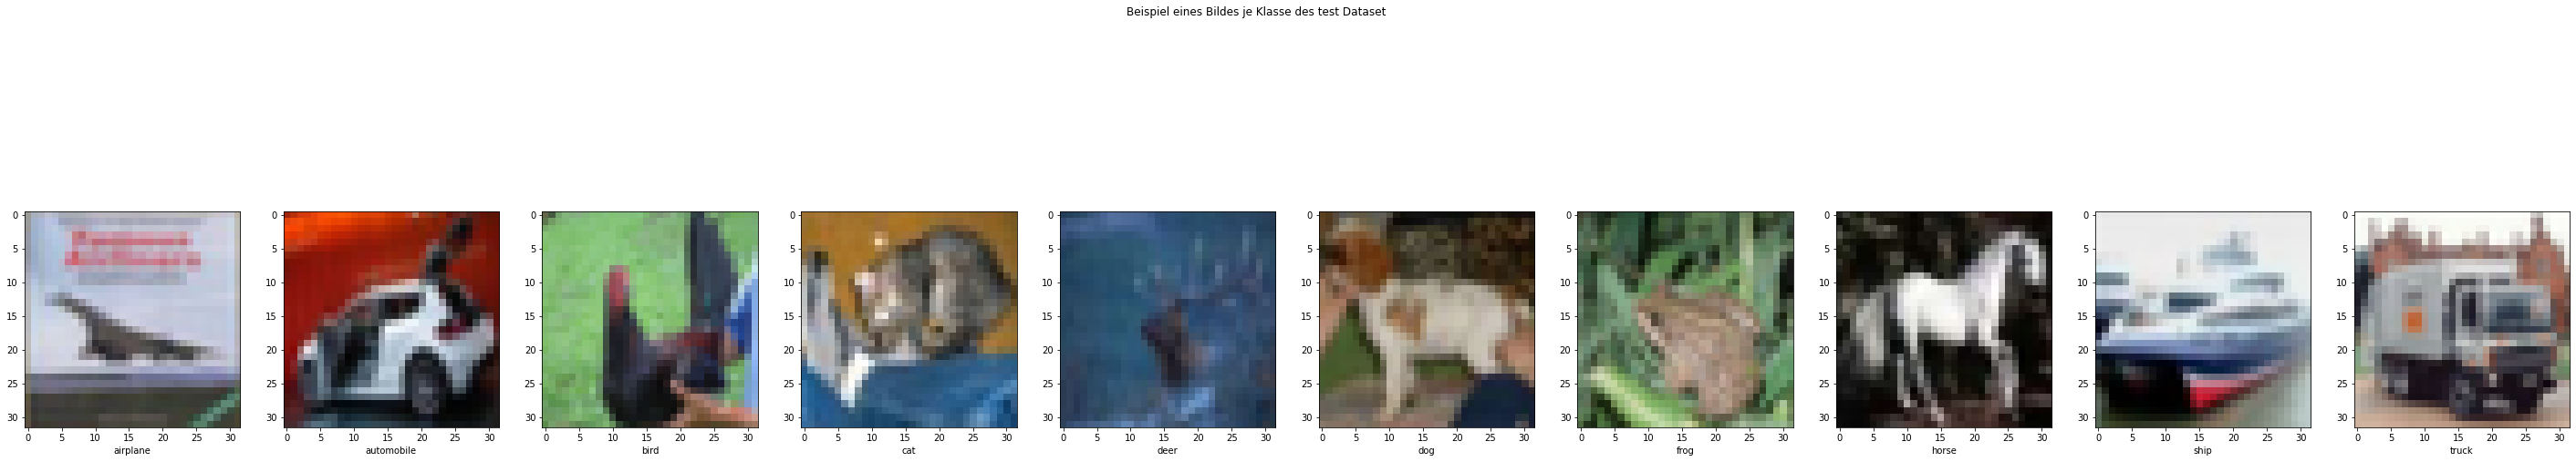

In [5]:
#trainings datensatz
_, counts = np.unique(np.array(trainset_full.targets)[trainset.indices], return_counts=True)
print("Data shape von train Dataset", trainset_full.data[trainset.indices].shape)

plt.figure(figsize=(30, 10))
plt.bar(trainset_full.classes, counts)
plt.title("Train dataset: Anzahl Counts der Klassen")
plt.xlabel("Klasse")
plt.ylabel("Counts")
plt.show()

show_image_classes(trainset, "Beispiel eines Bildes je Klasse des train Dataset")

#validierungs datensatz
_, counts = np.unique(np.array(trainset_full.targets)[validationset.indices], return_counts=True)
print("Data shape von validierungs-Dataset", trainset_full.data[validationset.indices].shape)

plt.figure(figsize=(30, 10))
plt.bar(trainset_full.classes, counts)
plt.title("Validierungs-Dataset: Anzahl Counts der Klassen")
plt.xlabel("Klasse")
plt.ylabel("Counts")
plt.show()

show_image_classes(validationset, "Beispiel eines Bildes je Klasse des train Dataset")

#test datensatz
_, counts = np.unique(testset.targets, return_counts=True)
print("Data shape von test Dataset", testset.data.shape)

plt.figure(figsize=(30, 10))
plt.bar(testset.classes, counts)
plt.title("Test Dataset: Anzahl Counts der Klassen")
plt.xlabel("Klasse")
plt.ylabel("Counts")
plt.show()

show_image_classes(testset, "Beispiel eines Bildes je Klasse des test Dataset")

Der CIFAR-10 Datensatz ist ein Datensatz aus 60'000 Bildern.<br>
Die Einzelnen Bilder haben eine Grösse von 32x32 Farb-Pixeln .<br>

Hierbei ist der Datensatz in folgende 10 Klassen unterteilt:
- Flugzeuge
- Autos
- Vögel
- Katzen
- Rehe
- Hunde
- Frösche
- Pferde
- Schiffe
- Lastwagen

Jede klasse enthält insgesamt 6'000 verschiedene Bilder, auf welchen ein Gegenstand oder Tier der jeweiligen Klasse zu erkennen ist.<br>

CIFAR-10 ist in ein train und ein Test Datensatz aufgeteilt.<br>
Der Train-datensatz hat eine Grösse von 50'000 Bildern und der Test-datensatz eine Grösse von 10'000 Bildern.<br>
Auf beiden Datensätzen sind die 10 Klassen balanced.<br>

Bedeutet für den Train-datensatz:
- Jede Klasse hat insgesamt 4'000 Bilder aufgrund des Train-Validation split, welcher gemacht wurde

Bedeutet für den Validation-datensatz:
- Jede Klasse hat insgesamt 1'000 Bilder

Bedeutet für den Test-datensatz:
- Jede Klasse hat insgesamt 1'000 Bilder

# Modelle welche getestet werden

In [4]:
class Linear(nn.Linear):
    """ Overrides linear layer from pytorch since wrong intialization method is used
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)

    def reset_parameters(self) -> None:
        """Kaiming he initialization with relu
        """
        nn.init.kaiming_uniform_(self.weight, nonlinearity="relu")
        if self.bias is not None:
            nn.init.zeros_(self.bias)

class Net_1C_2L_Small(nn.Module):
    def __init__(self):
        """Baseline Modell mit einem Convolutional Layer und zwei linearen Layern
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = Linear(196*10, 50)
        self.fc2 = Linear(50, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Net_1C_2L_Big(nn.Module):
    def __init__(self):
        """Gleiche Struktur wie baseline Modell, hat allerdings mehr Nodes auf dem hidden Layer
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = Linear(196*10, 120)
        self.fc2 = Linear(120, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Net_1C_3L_Small(nn.Module):
    def __init__(self):
        """Hat ein linearer Layer mehr als das baseline Modell. Hat allerdings nur 50 Nodes auf dem zusätzlichen Layer.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = Linear(196*10, 50)
        self.fc2 = Linear(50, 50)
        self.fc3 = Linear(50, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net_2C_3L_Small(nn.Module):
    def __init__(self):
        """Hat ein convolutional Layer und ein linearer Layer mehr als das baseline Modell.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = Linear(25*10, 50)
        self.fc2 = Linear(50, 50)
        self.fc3 = Linear(50, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net_2C_3L_Big(nn.Module):
    def __init__(self):
        """Selbe Struktur wie Net_2C_3L_Small allerdings mehr Nodes in den linearen Layern
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = Linear(25*10, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net_2C_3L_Huge(nn.Module):
    def __init__(self):
        """Selbe Struktur wie Net_2C_3L_Big allerdings mehr channels in den convolutions und ein kleinerer Kernel in der zweiten convolution
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = Linear(36*64, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net_2C_3L_Huge_Dropout(nn.Module):
    def __init__(self):
        """Selbe Struktur wie Net_2C_3L_Huge, besitzt allerdings noch dropout layer
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc1 = Linear(36*64, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = torch.flatten(x, 1)

        x = self.dropout1(x)
        x = self.dropout2(F.relu(self.fc1(x)))
        x = self.dropout3(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
class Net_2C_3L_Huge_BN(nn.Module):
    def __init__(self):
        """Selbe Struktur wie Net_2C_3L_Huge, besitzt allerdings noch batchnorm layer
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

        self.bn1 = nn.BatchNorm1d(36*64)
        self.bn2 = nn.BatchNorm1d(120)
        self.bn3 = nn.BatchNorm1d(84)

        self.fc1 = Linear(36*64, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = torch.flatten(x, 1)
        
        x = self.bn1(x)
        x = F.relu(self.bn2(self.fc1(x)))
        x = F.relu(self.bn3(self.fc2(x)))
        x = self.fc3(x)
        return x

In [9]:
def show_number_of_params(model_class):
    print(f"Number of learnable parameters in {model_class.__name__}:", sum(p.numel() for p in model_class().parameters() if p.requires_grad))

show_number_of_params(Net_1C_2L_Small)
show_number_of_params(Net_1C_2L_Big)
show_number_of_params(Net_1C_3L_Small)
show_number_of_params(Net_2C_3L_Small)
show_number_of_params(Net_2C_3L_Big)
show_number_of_params(Net_2C_3L_Huge)
show_number_of_params(Net_2C_3L_Huge_Dropout)
show_number_of_params(Net_2C_3L_Huge_BN)

Number of learnable parameters in Net_1C_2L_Small: 99320
Number of learnable parameters in Net_1C_2L_Big: 237290
Number of learnable parameters in Net_1C_3L_Small: 101870
Number of learnable parameters in Net_2C_3L_Small: 18880
Number of learnable parameters in Net_2C_3L_Big: 44404
Number of learnable parameters in Net_2C_3L_Huge: 308542
Number of learnable parameters in Net_2C_3L_Huge_Dropout: 308542
Number of learnable parameters in Net_2C_3L_Huge_BN: 313558


Im Rahmen der MC1 sollen Bilder mit einer Auflösung von 32x32 Pixeln zehn verschiedenen Klassen zugeordnet werden. Dabei steht die Accuracy im Fokus, um verschiedene **Modellarchitekturen** zu vergleichen und die Auswirkungen ihrer Eigenschaften auf die Vorhersagegenauigkeit zu untersuchen. **Hyperparameter** wie die Learning-rate oder Batch-size werden ebenfalls betrachtet, um ihre Auswirkungen auf die Performance zu analysieren.

Folgende **Modelle** werden untersucht:

- **Net_1C_2L_Small**: Dieses Modell dient als Baseline und ist mit nur einem conv. Layer und zwei linearen Layern ausgestattet, die lediglich 50 Nodes enthalten - es ist somit das einfachste Modell.
- **Net_1C_2L_Big**: Dieses Modell hat die gleiche Struktur wie das Baseline-Modell, verfügt jedoch über mehr Nodes im ersten linearen Layer. Hierdurch soll untersucht werden, ob und inwiefern das Modell im Vergleich zur Baseline performt.
- **Net_1C_3L_Small**: Im Vergleich zur Baseline verfügt dieses Modell über einen zusätzlichen linearen Layer. Auch hier soll untersucht werden, ob und inwiefern sich die Performance dadurch verbessert. Der zusätzliche Layer enthält ebenfalls nur 50 Nodes, um den Einfluss des zusätzlichen Layers in Net_1C_2L_Big zu isolieren.
- **Net_2C_3L_Small**: Im Gegensatz zur Baseline enthält dieses Modell ein zusätzliches conv. Layer, die Struktur der linearen Layer ist jedoch identisch zu Net_1C_3L_Small. Es soll untersucht werden, ob sich die Performance im Vergleich zu Net_1C_3L_Small, das ein conv. Layer weniger besitzt, verbessert.
- **Net_2C_3L_Big**: Dieses Modell hat die gleiche Struktur wie **Net_2C_3L_Small**, besitzt allerdings mehr Nodes in den linearen Layern.
- **Net_2C_3L_Huge**: Dieses Modell hat die gleiche Struktur wie **Net_2C_3L_Big**, besitzt allerdings mehr channels und einen kleinreren Kernel im zweiten conv. Layer.
- **Net_2C_3L_Huge_Dropout**: Dieses Modell hat die gleiche Struktur wie **Net_2C_3L_Huge**, besitzt allerdings noch zusätzliche dropout Layer zwischen den linear Layern. (Wird erst nach dem Hyperparameter-tuning verwendet)
- **Net_2C_3L_Huge_BN**: Dieses Modell hat die gleiche Struktur wie **Net_2C_3L_Huge**, besitzt allerdings Batchnorm layer zwischen den linearen Layer.

# Testen der trainings Basisfunktionalität

In diesem Test soll gezeigt werden, dass die Basisfunktionalität der Trainingsfunktion funktioniert.

Hierbei wird das Net_1C_2L_Small trainiert, wobei nur 64 Observationen verwendet werden soll.

Das Ziel ist ein Overfit auf diese 64 Samples zu erreichen.

Nach genüngend langem Training sollte das Modell die Trainingsdaten beinahe perfekt Vorhersagen können, wobei die Vorhersage auf dem Testset relativ schlecht sein sollte.

In [ ]:
run_name = "overfit_on_subset"

params = {
    "batchsize":8,
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.01},
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50
}

train_subset = Subset(trainset, np.random.choice(range(len(trainset)), size=64)) #hole ein subset von 64 Observationen aus dem trainset

WANDB_simple_train_test(project_name, params, "cuda:0", Net_1C_2L_Small).start(train_subset, test_dataset=testset, valid_dataset=validationset, run_id=run_name)

In [18]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/Overfit-von-Net_1C_2L_Small--Vmlldzo0MTkyODM3", width="100%", height="1024px")

# Was passiert, wenn die Modellparameter mit der Pytorch standard Initialisierung durchgeführt wird?

In diesem zusätzlichen Test soll verglichen werden, was passiert, falls man die Initialisierung für die Weights falsch wählt.

Dazu wird statt der Kaiming He Intialisierung für die Relu Activation, die standard Initialisierung von Pytorch verwendet.

In [ ]:
class Net_1C_2L_Small_WrongInit(nn.Module):
    def __init__(self):
        """Baseline Modell mit falscher Initialisierung
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(196*10, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
run_name = "overfit_on_subset_wrong_initialization"

WANDB_simple_train_test(project_name, params, "cuda:0", Net_1C_2L_Small_WrongInit).start(train_subset, test_dataset=testset, valid_dataset=validationset, run_id=run_name)

In [19]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/Kaiming-He-ReLu-vs-Pytorch-standard-Initialization---Vmlldzo0MTkzMDAz", width="100%", height="1024px")

# Evaluierung

Die Evaluierung dient dazu, die einzelnen Modelle zu testen und zu verbessern.

Im ersten Schritt soll untersucht werden, welches der Modelle das Klassifikationsproblem am besten lösen kann, wenn Stochastic Gradient Descent (ohne Beschleunigung), ohne Regularisierung und ohne Batch-Normalisierung verwendet werden. Hierbei werden Hyperparameter wie Lernrate und Batch-Size optimiert, um ein stabiles Training zu gewährleisten.

Um die Performance zu messen, wird der Loss (Cross Entropy) und die Accuracy verwendet. Die Accuracy wurde gewählt, da diese einfach zu berechnen und intuitiv zu verstehen ist. Da das Datenset bezüglich der Klassenverteilung gut ausbalanciert ist, kann die Accuracy auch ohne grosse Bedenken verwendet werden um daran die overall Modell-performace zu messen.

Im zweiten Teil wird der Nutzen der Regularisierung untersucht, wobei L1/L2 Weight Penalty und Dropout zum Einsatz kommen.

Im dritten Teil wird untersucht, ob und welche Vorteile die Batch-Normalisierung bietet. Zusätzlich wird die Idee der Batch-Normalisierung erläutert und erörtert, wie sie beim Training von neuronalen Netzen helfen kann.

Im letzten Teil wird der Nutzen des Adam-Optimierers untersucht. Hierbei wird erläutert, wie Adam im Hintergrund funktioniert und was seine Vorteile gegenüber von SGD sind.


## Training mit SGD ohne Gegularisierung und ohne Batchnorm

### Vorgehen

In den folgenden Experimenten werden die Hyperparameter der einzelnen Modelle so optimiert, dass der Loss des Validierungs-datensatzes so klein wie möglich ist.

In jedem Experiment wird ein Modell optimiert um herauszufinden, welche Hyperparameter-kombination für dieses Modell am besten funktioniert.

Zuletzt werden die Hyperparameter-favoriten der einzelnen Modelle miteinander verglichen und das beste ausgewählt.

Anschliessend werden die Fehler der Metrikten durch eine Cross-validation geschätzt, bei welcher somit unterschiedliche Train- und Validierungsdatensätze simuliert werden und zusätzlich der Effekt der Modellparameter-initialisierung einfliessen kann.

Diese Hyperparameter werden ausprobiert:
- Batchsize
- Lernrate
- Epochen

Folgende Dinge werden erwartet:

`Batchsize`:

Die Batchsize entscheidet, wieviele Observationen in die berechnung des Gradienten einfliessen, bevor die Parameter des Netzes geupdatet werden.

Bedeutet also, dass eine kleinere Batchsize ein öfteres Aktualisieren der Parameter mit sich zieht und auch verhindern kann, dass sich das Modell in einem lokalen Minima oder Satterpunkt verfängt.

Allerdings ist es möglich, dass der Gradientenabstieg dann nicht genau in die Richtung des globalen Minima geht, sondern nur ungefär.

`Lernrate`:

Die Lernrate bestimmt, in wie gross die Schritte des Updates der Parameter des Netzes letztendlich sind.

Eine kleine Lernrate sorgt dafür, dass die Modellparameter jeweils nur leicht geändert werden. Somit kommt der Gradientenabstieg allerdings möglicherweise nur langsam vorwärts.

Eine grosse Lernrate sorgt für grosse Updates der Modellparameter. Dies sorgt dafür, dass der Gradientenabstieg schneller zum globalen Minima kommt. Ist die Lernrate allerdings zu gross, ist es möglich, dass der Abstieg nicht in enge Täler herunterkommt und somit beginnt zu divergieren (der Trainingsvorgang wird instabil).


`Epochen`:

Die Anzahl Epochen bestimmen, wie oft über den ganzen Trainingsdatensatz gelert werden soll.

Je grösser diese Anzahl, desto besser wird das Modell auf der vorhersage auf dem Trainingsdatensatz.

Wählt man diese zu klein, dann hat das Modell noch nicht sein ganzes Potential entfaltet.

Ist die Anzahl Epochen zu gross, dann beginnt das Modell die Einzelheiten des Trainingsdatensatzes zu lernen und gleichzeitig werden die vorhersagen auf dem Testdatensatz schlechter.

Wie die Epochen gewählt werden, hängt gleichzeitig auch von der Lernrate und Batchsize ab, da anhand von diesen Parametern bestimmt wird, wie schnell das Modell auf einer Epoche lernt.

### Initialisierung der Modellparameter

Die Initialisierung der Weights bei einem neuralen Netz sind von betrachtlicher Wichtigkeit.

Sollten diese nämlich nicht zum Gunsten des Netzes initialisiert werden, kann dies zu einer Verlangsamung oder Destabilisierung des Trainings führen, was auf vanishing oder exploding Gradients zurückzuführen ist.

Pytorch initialisiert die linearen Layer standardmässig mit der Kaiming He Methode (Leaky ReLu mit a=sqrt(5)) aus backward compability gründen.

Da hier die Relu Aktivierungsfunktion verwendet wird, muss der gain abgeändert werden, und nach Paper der Bias mit 0 initialisiert werden.

Des weiteren gibt es noch die Xavier Initialisierung, welche allerdings nicht für die ReLu Aktivierungsfunktion geeignet ist.

### Hyperparameter tuning

In [43]:
params = {
    "batchsize":{"values":[16,32,64]},
    "num_classes":{"values":[10]},
    "optimizer_kwargs":{"parameters":{"lr":{"values":[7E-3,1E-2,4E-2]}}},
    "dl_num_workers":{"values":[os.cpu_count()]},
    "dl_shuffle":{"values":[True]},
    "epochs":{"values":[5,10,15,20]}
}

In [ ]:
sweep_name = "Net_1C_2L_Small"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_1C_2L_Small).start(sweep_name, params, trainset, testset, validationset)

In [20]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/HPT-Net_1C_2L_Small--Vmlldzo0MTkzNDY4", width="100%", height="1024px")

In [ ]:
sweep_name = "Net_1C_2L_Big"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_1C_2L_Big).start(sweep_name, params, trainset, testset, validationset)

In [21]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/HPT-Net_1C_2L_Big---Vmlldzo0MTk2MTcx", width="100%", height="1024px")

In [ ]:
sweep_name = "Net_1C_3L_Small"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_1C_3L_Small).start(sweep_name, params, trainset, testset, validationset)

In [22]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/HPT-Net_1C_3L_Small---Vmlldzo0MTk3NDMz", width="100%", height="1024px")

In [ ]:
sweep_name = "Net_2C_3L_Small"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_2C_3L_Small).start(sweep_name, params, trainset, testset, validationset)

In [23]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/HPT-Net_2C_3L_Small---Vmlldzo0MTk3NDk1", width="100%", height="1024px")

In [ ]:
sweep_name = "Net_2C_3L_Big"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_2C_3L_Big).start(sweep_name, params, trainset, testset, validationset)

In [24]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/HPT-Net_2C_3L_Big---Vmlldzo0MTk3NjAx", width="100%", height="1024px")

In [ ]:
sweep_name = "Net_2C_3L_Huge"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_2C_3L_Huge).start(sweep_name, params, trainset, testset, validationset)

In [25]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/HPT-Net_2C_3L_Huge--Vmlldzo0MjA0NTMz", width="100%", height="1024px")

### Bestes modell

In [ ]:
cv_name = "cv_Net_1C_2L_Small"

#beste parameter für dieses Modell
params = {
    "batchsize":32, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.01}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_1C_2L_Small).start(trainset_full, testset)


cv_name = "cv_Net_1C_2L_Big"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_1C_2L_Big).start(trainset_full, testset)


cv_name = "cv_Net_1C_3L_Small"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_1C_3L_Small).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Small"

#beste parameter für dieses Modell
params = {
    "batchsize":16, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Small).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Big"

#beste parameter für dieses Modell
params = {
    "batchsize":16, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Big).start(trainset_full, testset)


cv_name = "Net_2C_3L_Huge"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)

In [26]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/Bester-Modelltyp--Vmlldzo0MTk3Njgw", width="100%", height="1024px")

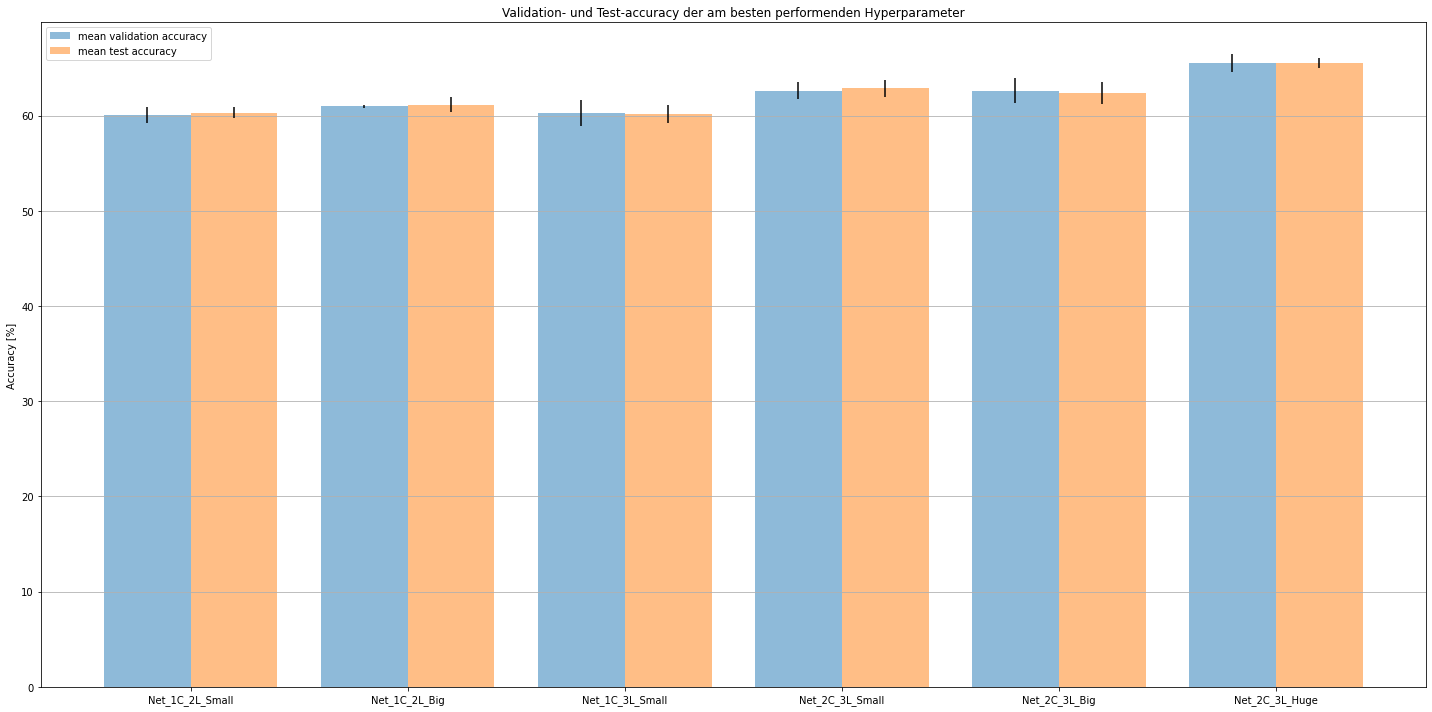

In [110]:
#Daten von Tabelle in Report 'Bester Modelltyp'
materials = ['Net_1C_2L_Small', 'Net_1C_2L_Big', 'Net_1C_3L_Small', "Net_2C_3L_Small", "Net_2C_3L_Big", "Net_2C_3L_Huge"]
x_pos = np.arange(len(materials))
CTEs_val = [60.06, 60.97, 60.28, 62.61, 62.64, 65.54]
CTEs_test = [60.28, 61.13, 60.14, 62.87, 62.35, 65.53]
error_val = [0.809, 0.176, 1.332, 0.882, 1.31, 0.93]
error_test = [0.579, 0.791, 0.943, 0.885, 1.141, 0.539]

# Build the plot
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x_pos - 0.2, CTEs_val, yerr=error_val, align='center', width=0.4, alpha=0.5, ecolor='black', label="mean validation accuracy")
ax.bar(x_pos + 0.2, CTEs_test, yerr=error_test, align='center', width=0.4, alpha=0.5, ecolor='black', label="mean test accuracy")
ax.set_ylabel('Accuracy [%]')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Validation- und Test-accuracy der am besten performenden Hyperparameter')
ax.yaxis.grid(True)

# show
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In diesem Plot sieht man nochmals visuell die Ergebnisse aus der Tabelle des Reports 'Bester Modelltyp'

Dieser zeigt nochmals, dass das das Modell mit zwei Convolutions und drei linearen Layern mit vielen Filtern am besten peformt (Net_2C_3L_Huge).

Wie bereits erwähnt, ist deutlich zu erkennen, dass die Struktur der linearen Layern im Falle von Bildern keine grosse Rolle spielt, da diese alleine offensichtlich nicht in der Lage sind Strukturen in den Bilddaten zu erkennen.

Viel wichtiger sind die Convolutions, welche einem Modell schlussendlich seinen Performance boost verleiht.

Möglicherweise könnte der Generalisierungsfehler noch weiter verkleinert werden, indem noch weitere Convolutions eingesetzt würden.

## Nutzen der Regularisierung

Regularisierung hat das Ziel eine Überanpassung eines Modelles an die Trainingsdaten zu vermeiden.

Dadurch kann verhindert werden, dass das Modell die Trainingsdaten spezifischen Muster lernt, was allerdings dazu führt, dass sich die Vorhersagegenauigkeit auf ungesehenen Daten erheblich verschlechtert.

Regularisierung schränkt das Modell zusätzlich in seiner Flexibilität ein, sodass dieses besser generalisiert.


Zur Regularisierung gibt es verschiedene Methoden:
- Training stoppen, sobald der loss auf dem Validierungsset sein Minimum erreicht hat
- Modellparameter einschränken
- Dropout
- Vielfältigkeit des Trainingsset erhöhen

### L2 Regularisierung

Die L2 Regularisierung fügt dem Loss ein zusätzlichen Strafterm hinzu.

Dieser Strafterm ist einfach die Summe aller Weights im Quadrat.

Die Regularisierungsstärke lässt sich durch einen zusätzlichen Parameter $\lambda$ beeinflussen.

Je grösser $\lambda$, desto stärker wird das Modell regularisiert.

**Formel**:

$
\hat{loss} = loss +\lambda \sum_{i=1}^{n} \theta_{i}^{2}
$

Die L2 Regularisierung bestraft vorallem Weights, welche sehr stark positiv/negativ sind, da diese im Quadrat gerechnet werden.

Das Modell versucht also mit dieser Regularisierung die Weights so klein wie möglich zu halten.

In [ ]:
cv_name = "cv_Net_2C_3L_Huge_l2__0.001"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.001, #set alpha
    "l_regularization":2, #l2 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Huge_l2__0.01"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.01, #set alpha
    "l_regularization":2, #l2 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Huge_l2__0.1"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.1, #set alpha
    "l_regularization":2, #l2 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Huge_l2__0.15"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.15, #set alpha
    "l_regularization":2, #l2 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)

### L1 Regularisierung

Die L1 Regularisierung fügt wie die L1, dem Loss ein zusätzlichen Strafterm hinzu.

Dieser Strafterm ist einfach die Summe aller absoluten Weights.

Die Regularisierungsstärke lässt sich durch einen zusätzlichen Parameter $\lambda$ beeinflussen.

Je grösser $\lambda$, desto stärker wird das Modell regularisiert.

**Formel**:

$
\hat{loss} = loss +\lambda \sum_{i=1}^{n} |\theta_{i}|
$

Die L2 Regularisierung bestraft alle weights gleich stark unabhängig davon, ob diese gross oder klein sind.

Diese Regularisierungsart versucht so viele Weights wie möglich auf 0 zu setzten.

In [ ]:
cv_name = "cv_Net_2C_3L_Huge_l1__0.0001"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.0001, #set alpha
    "l_regularization":1, #l1 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Huge_l1__0.001"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.001, #set alpha
    "l_regularization":1, #l1 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)


cv_name = "cv_Net_2C_3L_Huge_l1__0.01"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "alpha":0.01, #set alpha
    "l_regularization":1, #l1 regularization
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset_full, testset)

### Dropout

Dropout ist eine Regularisierungsmethode, bei welcher während dem Training zufällig Nodes abgeschaltet werden.

Die Wahrscheinlichkeit kann dabei eingestellt werden.

Ohne Dropout ist es möglich, dass das Modell spezifische Verbindungen zwischen Nodes bevorzugt und somit der Einfluss von bestimmten Nodes auf das Resultat sehr gross wird (co-adaptations).

Mit Dropout ist das Modell gezwungen alle Nodes in die Berechnung des Outputs mithinein zu beziehen.

Dies hat zur folge, dass einzelne Weights nicht mehr so gross werden können, da alle Verbindungen zur nächsten Node dazu beitragen müssen, was einen ähnlichen Effekt hat wie die L2 Regularisierung.

Somit ist es für das Modell schwieriger spezifische Dinge im Trainingsdatenset zu lernen.

In [ ]:
#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":200, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

cv_name = "cv_2_Net_2C_3L_Huge_Dropout"

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge_Dropout).start(trainset_full, testset)

In [27]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/Regularization--Vmlldzo0MjE0MTcw", width="100%", height="1024px")

## Nutzen von Batchnorm

Die Batchnorm ist ein zusätzlicher Layer, welcher in ein neurales Netz eingefügt werden kann, z.B. zwischen lineare Layer.

Dieser layer führt eine Standardisierung über einen ganzen Batch durch, wobei $\gamma$ und $\beta$ zwei erlernbare Parameter sind.

Formeln für die Batchnorm:

$ \mu_B = \frac{1}{m}\sum_{i=1}^{m}x_i $

$ \sigma_B^2 = \frac{1}{m}\sum_{i=1}^{m}(x_i - \mu_B)^2 $

$ \hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} $

$ y_i = \gamma \hat{x_i} + \beta $

Wird die Batchnorm zwischen zwei linearen Layern eingefügt, so sorgt diese dafür, dass die Verteilung der Inputdaten in den darauffolgenden Layer ungefär normalverteilt ist.

Dadurch ist die Wahrscheinlichkeit, dass der Output einer Node im linearen Berech von z.B. der Sigmoid activation landet, höher als ohne Batchnorm.

Dadurch wird der Gradientenabstieg stabiler und auch schneller, da die Nodes meisst nicht in der Sättigung, sondern im steilsten Berech der Aktivierungsfunktionen landen.

Die obigen Formeln werden allerdings nur während des Trainings genutzt.

Sobald das Modell perdicten soll, ist es unter Umständen nicht mehr möglich die Standardabweichung zu berechnen (z.B. falls nur auf einer Observation predicted wird).

In diesem Fall wird ein exponentially weighted mean von $\mu_B$ und $\sigma_B^2$ verwendet.

In [ ]:
cv_name = "cv_Net_2C_3L_Huge_BN"

#beste parameter für dieses Modell
params = {
    "batchsize":64, #best batchsize for this model
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.007}, #best learning rate for this model
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50, #train as long as required
    "k_folds":5 #split into 5 folds, use 4 for training (40000 images) and validate with 1 (10000)
}

WANDB_train_validate_cv(project_name, cv_name, params, "cuda:0", Net_2C_3L_Huge_BN).start(trainset_full, testset)

In [ ]:
params = {
    "batchsize":{"values":[64]},
    "num_classes":{"values":[10]},
    "optimizer_kwargs":{"parameters":{"lr":{"values":[0.007, 0.13025, 0.2535 , 0.37675, 0.5]}}},
    "dl_num_workers":{"values":[os.cpu_count()]},
    "dl_shuffle":{"values":[True]},
    "epochs":{"values":[50]}
}

sweep_name = "Net_2C_3L_Huge_BN_bigger_lr_test"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_2C_3L_Huge_BN).start(sweep_name, params, trainset, testset, validationset)

In [ ]:
run_name = "Net_2C_3L_Huge_bigLR05"

#probiere eine grosse learning rate ohne batchnorm
params = {
    "batchsize":64,
    "num_classes":10,
    "optimizer_kwargs":{"lr":0.5},
    "dl_num_workers":os.cpu_count(),
    "dl_shuffle":True,
    "epochs":50
}

WANDB_simple_train_test(project_name, params, "cuda:0", Net_2C_3L_Huge).start(trainset, testset, validationset, run_id=run_name)

In [28]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/Batchnorm--Vmlldzo0MjE1OTc3", width="100%", height="1024px")

## Adam optimizer

Der Adam Optimizer ist eine kombination aus Momentum und RMS Prop.

Im gegensatz zum SGD nutzt er nicht die gleiche learning Rate für alle Komponenten des Gradienten.

Adam versucht diese so anzupassen, dass Gradientenkomponenten, welche eher klein sind zu beschleunigen und grosse abzubremsen (Effekt von RMS Prop).

Des weiteren dämpft er starke Richtungsänderungen im Gradienten durch den effekt des Momentum ab.


Durch die Dämpfung von grossen Gradientenkomponenten und nutzen des Momentums, sollte dieser schneller an das globale Minima herankommen wie SGD.

In [6]:
params = {
    "batchsize":{"values":[64]},
    "num_classes":{"values":[10]},
    "optimizer_kwargs":{"parameters":{"lr":{"values":[0.0001, 0.0004, 0.0007, 0.001]}}},
    "dl_num_workers":{"values":[os.cpu_count()]},
    "dl_shuffle":{"values":[True]},
    "epochs":{"values":[100]}
}

In [ ]:
sweep_name = "Net_2C_3L_Huge_Adam"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_2C_3L_Huge, optimizer_class=optimizers.Adam).start(sweep_name, params, trainset, testset, validationset)


sweep_name = "Net_2C_3L_Huge_Dropout_Adam"

WANDB_optimize_hyperparams(project_name, "cuda:0", Net_2C_3L_Huge_Dropout, optimizer_class=optimizers.Adam).start(sweep_name, params, trainset, testset, validationset)

In [29]:
IFrame("https://wandb.ai/t_buess/del_mc1/reports/Adam-Optimizer--Vmlldzo0MjE2ODI2", width="100%", height="1024px")

# Conclusion

In dieser MC wurden verschiedene Modelle mit unterschiedlichem Aufbau getestet und versucht dessen Hyperparameter so zu optimieren um deren maximale Accuracy herauszuholen.

Dabei war es auffällig, dass die linearen Layer nicht wirklich einen grossen Einfluss auf den Generalisierungsfehler haben.

Umso wichtiger sind dabei allerdings die convolutional Layers, welche den Modellen den Performance boost verleihen.

Das beste Modell (Net_2C_3L_Huge) verwendete nur 2 convolutional Layers, wobei ohne weiteres eine Accuracy von ungefär 65.5% erreicht wurde auf dem Testdatensatz.

Würden mehr convolutional Layers eingesetzt, dann wäre möglicherweise die Performance noch besser.

Die L1/L2 Regularisierung hat leider keine erheblich bessere Performance erwirkt.

Dropout auf den linearen Layern hingegen konnte die Validierungs-accuracy des Net_2C_3L_Huge Modell auf ungefär 71% anheben.

Die Batchnorm zwischen den linearnen Layern hatte den Effekt, dass mit einer höheren Learning-rate trainiert werden konnte.

Allerdings bot diese keinen verbessernden Wirkung auf die Validation-accuracy.

Der Adam Optimizer hat bezüglich der Validation-accuracy keine Verbesserung gezeigt.

Allerdings ist das Training mit dem Adam um einiges schneller, weshalb es sich lohnt mit diesem statt mit SGD zu trainieren.


Abschliessend würde ich für diesen Task das Modell Net_2C_3L_Huge_Dropout empfehlen, da dieses die beste Validation-accuracy erreichte.

Um Rechenzeit zu sparen empfehle ich den Adam Optimizer mit einer Learning-rate von 0.0004.

Des weiteren könnte die Validation-accuracy des Modelles möglicherweise noch verbessert werden, wenn mehr conv. Layers verwendet würden.

Denn bereits ein Vergrössern deren Output-channels konnte die Validation-accuracy signifikant anheben.